In [2]:
from wrangle_data_funcs import *
from modelling_funcs import *
from predict_gw_scores import *
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from outputs.other_funcs import *

from scipy import stats

In [ ]:
training_years, training_n_gws, pred_year, pred_gw, alpha, rolling_gws, features, model_func, avg_type, output = get_params()

In [10]:
training_df = get_training_df(training_years, training_n_gws, avg_type, alpha, rolling_gws)

KeyboardInterrupt: 

In [ ]:
training_years, training_n_gws, pred_year, pred_gw, alpha, rolling_gws, features, model_func, avg_type, output = get_params()
# print(training_year, training_n_gws, pred_year, pred_gw, alpha, features, model, output)
training_df = get_training_df(training_years, training_n_gws, avg_type, alpha, rolling_gws)
training_df_scaled, _ = scale_df(training_df, features)
_ = test_model(training_df_scaled, features, model_func)
prediction_df = get_prediction_df(pred_year, pred_gw, avg_type, alpha, rolling_gws)
prediction_df_scaled, _ = scale_df(prediction_df, features)
pred_df = train_full_model(training_df_scaled, features, prediction_df_scaled, model_func)
pred_df = merge_ownership_data(pred_df)
pred_df_simple = pred_df[['full_name', 'position', 'team', 'ewma_total_points', 'predicted_points', 'owner']]

c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.295, 'DEF': 2.257, 'MID': 2.221, 'FWD': 2.528}


# Checking coeffs

In [3]:
def train_full_model(training_df, features, prediction_df, model_func):
    model_dict, _ = create_model(training_df, features, model_func, test=False)
    pred_df = predict_scores(prediction_df.dropna(), features, model_dict)
    return pred_df, model_dict

In [45]:
training_years, training_n_gws, pred_year, pred_gw, alpha, rolling_gws, features, model_func, avg_type, output = get_params()
rolling_gws = 38
features = features + [f'ewma_points_conceded_{pos}_nw_opponent' for pos in ['GK', 'DEF', 'MID', 'FWD']]
# print(training_year, training_n_gws, pred_year, pred_gw, alpha, features, model, output)
training_df = get_training_df(training_years, training_n_gws, avg_type, alpha, rolling_gws)
training_df_scaled, _ = scale_df(training_df, features)
_ = test_model(training_df_scaled, features, model_func)
prediction_df = get_prediction_df(pred_year, pred_gw, avg_type, alpha, rolling_gws)
prediction_df_scaled, _ = scale_df(prediction_df, features)
pred_df, model_dict = train_full_model(training_df_scaled, features, prediction_df_scaled, model_func)
pred_df = merge_ownership_data(pred_df)
pred_df_simple = pred_df[['full_name', 'position', 'team', 'ewma_total_points', 'predicted_points', 'owner']]

c:\Users\dellis2\OneDrive - Illumina, Inc\Documents\fpl\draft_fpl_2526\transfer\wrangle_data_funcs.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gw_df = pd.concat(gw_df_list)


{'GK': 2.372, 'DEF': 2.317, 'MID': 2.285, 'FWD': 2.574}


In [14]:
coefs = pd.DataFrame({'GK': model_dict['GK'].coef_,
              'DEF': model_dict['DEF'].coef_,
              'MID': model_dict['MID'].coef_,
              'FWD': model_dict['FWD'].coef_}, index=features
              )

In [15]:
coefs

,GK,DEF,MID,FWD
xP,0.000000,0.000000,0.000000,0.000000
assists,0.000000,0.000000,0.000000,-0.000000
bonus,-0.000000,0.000000,-0.000000,0.000000
bps,0.238195,0.194074,0.004175,0.000000
clean_sheets,0.105161,0.022478,0.070163,0.000000
creativity,0.000000,0.115452,0.099901,0.062443
expected_assists,0.000000,0.000000,0.011854,0.053478
expected_goal_involvements,0.000000,0.000000,0.125768,0.000000
expected_goals,-0.000000,0.000000,0.000000,0.051946
expected_goals_conceded,-0.050246,-0.000000,0.000000,0.076063


In [47]:
test_df = pred_df.groupby('team').first()[['opponent_team_name']+[f'ewma_points_conceded_{pos}_nw_opponent' for pos in ['GK', 'DEF', 'MID', 'FWD']]]

In [55]:
test_df.sort_values('ewma_points_conceded_FWD_nw_opponent', ascending=False)

,opponent_team_name,ewma_points_conceded_GK_nw_opponent,ewma_points_conceded_DEF_nw_opponent,ewma_points_conceded_MID_nw_opponent,ewma_points_conceded_FWD_nw_opponent
team,,,,,
Chelsea,West Ham,0.081337,1.097696,0.317295,2.037415
Aston Villa,Brentford,0.348130,-0.248380,-0.371810,1.709959
Bournemouth,Wolves,2.682564,2.232622,1.876847,0.961488
Everton,Brighton,-0.252153,-0.921418,0.154086,0.914708
Sunderland,Burnley,0.014639,0.978924,1.695504,0.680811
Nott'm Forest,Crystal Palace,0.014639,0.239902,0.262892,0.353355
Liverpool,Newcastle,0.614922,0.371870,-0.553153,0.213017
Wolves,Bournemouth,-0.052059,-0.670678,0.825056,0.213017
Arsenal,Leeds,0.281432,0.451051,1.151474,0.119458


<Axes: xlabel='ewma_points_conceded_GK_nw_opponent', ylabel='total_points_nw'>

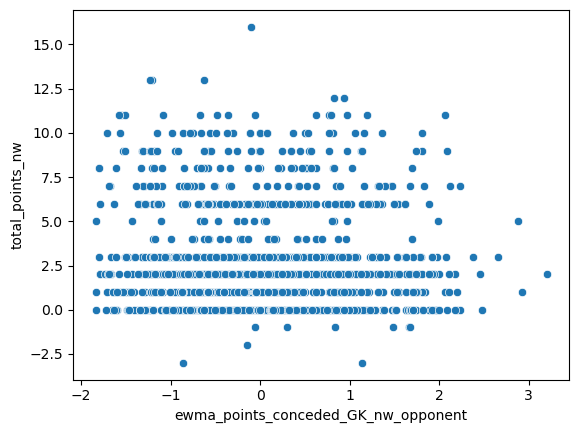

In [56]:
defenders = training_df.query('position=="GK" and minutes>0 and gw>18')

sns.scatterplot(data=defenders, y='total_points_nw', x='ewma_points_conceded_GK_nw_opponent')

## Testing "points_conceded" as a feature
There are a few options for how to do this. I will list from simplest to most complicated
* Sum of all points from each position
* Sum of all points from each position but only give model data from correct position
* Sum of points only for players who scored > 2
* Sum of points - appearance points (not sure exactly how to implement this)

In [ ]:
training_df_test = training_df.copy()

In [ ]:
training_df_test['total_points'] = training_df_test['total_points'].astype(int)

## Option 1

In [ ]:
points_conceded_df = training_df_test.groupby(['gw', 'year', 'opponent_team_name', 'position']
                                         ).sum(numeric_only=True)[['total_points']]

In [ ]:
points_conceded_df_combined = pd.DataFrame(index=points_conceded_df.loc[:,:,:, 'DEF'].index)
for pos in ['GK', 'DEF', 'MID', 'FWD']:
    points_conceded_df_pos = points_conceded_df.loc[:,:,:, pos]
    points_conceded_df_pos = points_conceded_df_pos.rename(columns={'total_points': f'points_conceded_{pos}'})
    points_conceded_df_combined = points_conceded_df_combined.merge(points_conceded_df_pos, left_index=True, right_index=True)
    
points_conceded_df_toMerge = points_conceded_df_combined.reset_index()

In [ ]:
points_conceded_df_toMerge

,gw,year,opponent_team_name,points_conceded_GK,points_conceded_DEF,points_conceded_MID,points_conceded_FWD
0,11,2023,Arsenal,3,8,13,0
1,11,2023,Aston Villa,10,20,26,3
2,11,2023,Bournemouth,2,10,15,8
3,11,2023,Brentford,1,4,11,3
4,11,2023,Brighton,10,27,16,14
...,...,...,...,...,...,...,...
1568,37,2025,Nott'm Forest,2,3,13,1
1569,37,2025,Southampton,6,30,16,16
1570,37,2025,Spurs,6,33,28,5
1571,37,2025,West Ham,3,15,27,2


In [ ]:
def get_fpl_points_scored_df(gw_df, year):
    points_conceded_groupby_cols = ['gw', 'opponent_team', 'position']
    points_conceded_df = gw_df.groupby(points_conceded_groupby_cols
                                            ).sum(numeric_only=True)[['total_points']]
    points_conceded_df_combined = pd.DataFrame(index=points_conceded_df.loc[:,:, 'DEF'].index)
    for pos in ['GK', 'DEF', 'MID', 'FWD']:
        points_conceded_df_pos = points_conceded_df.loc[:,:, pos]
        points_conceded_df_pos = points_conceded_df_pos.rename(columns={'total_points': f'points_conceded_{pos}'})
        points_conceded_df_combined = points_conceded_df_combined.merge(points_conceded_df_pos, left_index=True, right_index=True)

    teamcode_dict = get_teamcodes(year)
    points_conceded_df_combined = points_conceded_df_combined.reset_index(names=['gw', 'team'])
    points_conceded_df_combined['team'] = points_conceded_df_combined['team'].map(teamcode_dict)
    return points_conceded_df_combined[['team', 'gw'] + [f'points_conceded_{pos}' for pos in ['GK', 'DEF', 'MID', 'FWD']]]

## Implement option 1

In [ ]:
year = 25
gw = 38
rolling_gws=5
# def get_rolling_df(year, gw, rolling_gws):
gw_df = import_data_from_vastaav(year, gw)
gw_df = add_team_data(gw_df)

gw_df['full_name'] = gw_df['name'].apply(clean_name)

# Get player specific stats
player_value_cols = ['xP', 'assists', 'bonus', 'bps',
    'clean_sheets', 'creativity', 'expected_assists',
    'expected_goal_involvements', 'expected_goals',
    'expected_goals_conceded', 'goals_conceded', 'goals_scored',
    'ict_index', 'influence', 'minutes',
    'own_goals', 'penalties_missed', 'penalties_saved',
    'red_cards', 'saves', 'starts',
    'threat', 'total_points', 'transfers_balance',
    'transfers_in', 'transfers_out', 'value', 'yellow_cards']
merge_cols_players = ['full_name', 'gw', 'total_points', 'position','team','opponent_team']
ewma_gw_df_players = roll(gw_df, 'full_name', player_value_cols, {'total_points': 'ewma_total_points'}, merge_cols_players, rolling_gws)

# Get team specific stats
points_conceded_df = get_fpl_points_scored_df(gw_df, year)
gw_df_teams = get_teams_df(gw_df)
team_value_cols = ['team_goals', 'team_points'] + [f'points_conceded_{pos}' for pos in ['GK', 'DEF', 'MID', 'FWD']]
merge_cols_teams = ['team', 'gw']
gw_df_teams = gw_df_teams.merge(points_conceded_df, on=merge_cols_teams)
ewma_gw_df_teams = roll(gw_df_teams, 'team', team_value_cols, {'team_goals': 'ewma_team_goals',
                                                                'team_points': 'ewma_team_points',
                                                                'points_conceded_GK': 'ewma_points_conceded_GK',
                                                                'points_conceded_DEF': 'ewma_points_conceded_DEF',
                                                                'points_conceded_MID': 'ewma_points_conceded_MID',
                                                                'points_conceded_FWD': 'ewma_points_conceded_FWD'}, merge_cols_teams, rolling_gws)
merged_ewma_df = merge_ewma_dfs(ewma_gw_df_players, ewma_gw_df_teams, year)
    # return merged_ewma_df

In [ ]:
merged_ewma_df

,full_name,gw,total_points,position,team,opponent_team,xP,assists,bonus,bps,...,ewma_points_conceded_GK_x,ewma_points_conceded_DEF_x,ewma_points_conceded_MID_x,ewma_points_conceded_FWD_x,ewma_team_goals_nw_opponent,ewma_team_points_nw_opponent,ewma_points_conceded_GK_y,ewma_points_conceded_DEF_y,ewma_points_conceded_MID_y,ewma_points_conceded_FWD_y
0,aaron_anselmino,25,0,DEF,Chelsea,5,1.80,0.0,0.0,0.0,...,5.0,11.0,23.0,5.8,1.6,1.8,3.6,15.0,20.0,7.4
1,aaron_anselmino,26,0,DEF,Chelsea,2,1.15,0.0,0.0,0.0,...,5.0,12.2,23.2,6.0,1.2,1.2,3.6,15.6,24.4,5.0
2,aaron_anselmino,27,0,DEF,Chelsea,17,1.10,0.0,0.0,0.0,...,5.0,10.6,23.4,5.4,0.8,0.6,3.8,16.6,33.6,7.4
3,aaron_anselmino,28,0,DEF,Chelsea,11,0.95,0.0,0.0,0.0,...,5.4,10.6,22.0,3.4,0.0,0.0,7.6,28.0,32.8,6.0
4,aaron_anselmino,29,0,DEF,Chelsea,1,0.76,0.0,0.0,0.0,...,6.2,14.0,24.0,3.2,0.8,1.6,4.0,17.8,16.2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27600,zain_silcott_duberry,34,0,MID,Bournemouth,14,0.20,0.0,0.0,0.0,...,3.6,11.2,15.4,6.4,0.4,0.4,5.4,17.8,25.0,4.6
27601,zain_silcott_duberry,35,0,MID,Bournemouth,1,-0.10,0.0,0.0,0.0,...,3.2,9.6,17.6,4.4,1.8,1.6,2.4,8.0,16.8,9.6
27602,zain_silcott_duberry,36,0,MID,Bournemouth,2,-0.20,0.0,0.0,0.0,...,4.4,13.6,16.4,4.8,2.2,3.0,5.4,6.8,17.8,3.0
27603,zain_silcott_duberry,37,0,MID,Bournemouth,13,-0.30,0.0,0.0,0.0,...,4.2,13.2,21.8,6.4,2.2,2.6,3.4,12.4,17.4,3.6
